# Collapsed Gibbs sampler for Latent Dirichlet Allocation

<div style="display:none">
  $
      \newcommand{\dir}{\mathop{\rm Dirichlet}\nolimits}
      \newcommand{\dis}{\mathop{\rm Discrete}\nolimits}
      \newcommand{\btheta}{\mathbf{\theta}}
      \newcommand{\norm}[1]{\left\| #1 \right\|}
      \newcommand{\p}[1]{p \left( #1 \right)}
      \newcommand{\cp}[2]{p \left( #1 \middle| #2 \right)}
      \newcommand{\Betaf}{\mathop{\rm B}\nolimits}
      \newcommand{\Gammaf}{\mathop{\Gamma}\nolimits}
  $
</div>

Here is a full derivation of the collapsed Gibbs sampler for Latent Dirichlet Allocation.  The original ideas come from [this paper](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf) by Griffiths and Steyvers (2004).  I found the Wikipedia articles on [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) and the [Dirichlet-Multinomial distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) very helpful, as well as [these notes](https://people.cs.umass.edu/~wallach/courses/s11/cmpsci791ss/readings/griffiths02gibbs.pdf) by Griffiths.  My Gibbs sampler implementation in Cython closely follows [Allen Riddell](https://ariddell.org/)'s [LDA code](https://github.com/ariddell/lda/).

Recall the generative model:

$$\begin{align}
\theta^{(d)} & \sim \dir(\alpha) & \text{(topic distribution for document $d \in \{1, \ldots, D\}$)}\\
\phi^{(k)} & \sim \dir(\beta) & \text{(term distribution for topic $k \in \{1, \ldots, K\}$)}\\
z_n^{(d)} \mid \theta^{(d)} & \sim \dis(\theta^{(d)}) & \text{(topic of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)}\\
w_n^{(d)} \mid \phi^{(z_n^{(d)})} & \sim \dis(\phi^{(z_n^{(d)})}) & \text{(term of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)}
\end{align}$$

where each token can be any one of $V$ terms in our vocabulary.

![smoothed_lda](https://upload.wikimedia.org/wikipedia/commons/4/4d/Smoothed_LDA.png)

<p style='text-align: center; font-size: 10px;'>
"<a href="https://commons.wikimedia.org/wiki/File:Smoothed_LDA.png#/media/File:Smoothed_LDA.png">Smoothed LDA</a>" by <a href="//commons.wikimedia.org/w/index.php?title=User:Slxu.public&amp;action=edit&amp;redlink=1" class="new" title="User:Slxu.public (page does not exist)">Slxu.public</a> - <span class="int-own-work" lang="en">Own work</span>. Licensed under <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a> via <a href="https://commons.wikimedia.org/wiki/">Wikimedia Commons</a>.
</p>

<p style='text-align: center; font-style: italic;'>
Plate notation for latent Dirichlet allocation.  Please note that $M$ should be $D$.
</p>

Therefore, the joint probability distribution can be factorized as follows:

$$\begin{align}
\cp{\theta, \phi, z, w}{\alpha, \beta}
&= 
\prod_{k=1}^{K} \cp{\phi^{(k)}}{\beta}
\prod_{d=1}^{D} \cp{\theta^{(d)}}{\alpha}
\prod_{n=1}^{N^{(d)}} \cp{z_n^{(d)}}{\theta^{(d)}} \cp{w_n^{(d)}}{\phi^{(z_n^{(d)})}}
\\ &=
\prod_{k=1}^{K} \frac{\prod_{v=1}^{V} \left(\phi_v^{(k)}\right)^{\beta_v-1}}{\Betaf(\beta)}
\prod_{d=1}^{D} \frac{\prod_{k'=1}^{K} \left(\theta_{k'}^{(d)}\right)^{\alpha_{k'}-1}}{\Betaf(\alpha)}
\prod_{k''=1}^{K} \left(\theta_{k''}^{(d)}\right)^{a_{k''}^{(d)}}
\prod_{v'=1}^{V} \left(\phi_{v'}^{(k)}\right)^{b_{v'}^{(k)}}
\\ &=
\left( \prod_{k=1}^{K}
\frac{\prod_{v=1}^{V} \left( \phi_v^{(k)}\right)^{b_{v}^{(k)}+\beta_v-1}}{\Betaf(\beta)} \right)
\left( \prod_{d=1}^{D} \frac{\prod_{k'=1}^{K} \left( \theta_{k'}^{(d)} \right)^{a_{k'}^{(d)} + \alpha_{k'}-1}}{\Betaf(\alpha)} \right)
\\ &=
\left( \prod_{k=1}^{K}
\frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)}
\frac{\prod_{v=1}^{V} \left(\phi_v^{(k)}\right)^{b_{v}^{(k)}+\beta_v-1}}{\Betaf(b^{(k)} + \beta)} \right)
\left( \prod_{d=1}^{D}
\frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)}
\frac{\prod_{k'=1}^{K}
\left( \theta_{k'}^{(d)}\right)^{a_{k'}^{(d)} + \alpha_{k'}-1}}{\Betaf(a^{(d)} + \alpha)} \right)
\\ &=
\left( \prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)} \cp{\phi^{(k)}}{b^{(k)} + \beta} \right)
\left( \prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \cp{\theta^{(d)}}{a^{(d)} + \alpha} \right)
\end{align}$$

where $a_k^{(d)}$ is the number of tokens in document $d$ assigned to topic $k$, $b_v^{(k)}$ is the number of tokens equal to term $v$ and assigned to topic $k$, and $\Betaf$ is the [multivariate Beta function](https://en.wikipedia.org/wiki/Beta_function#Multivariate_beta_function).

In this form, we can easily marginalize out $\theta$ and $\phi$ by integrating with respect to each $\theta^{(d)}$ and $\phi^{(k)}$ over the standard simplexes $\Delta^{D-1}$ and $\Delta^{K-1}$, respectively, where

$$\Delta^{n-1} = \left\{x \in \mathbb{R}^n \middle| x \ge 0, \sum_{i=1}^n x_i = 1 \right\},$$

and noting that each integral is equal to 1 since each $p$ is a probability distribution over its respective sample space. Hence,

$$\begin{align}
\cp{z, w}{\alpha, \beta} &= 
\left( \prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)} \int_{\Delta^{K-1}} \cp{\phi^{(k)}}{b^{(k)} + \beta} d\phi^{(k)} \right)
\left( \prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \int_{\Delta^{D-1}} \cp{\theta^{(d)}}{a^{(d)} + \alpha} d\theta^{(d)} \right) \\ &=
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \\ &=
\cp{w}{z, \beta} \cp{z}{\alpha}.
\end{align}$$

Our goal is to calculate the posterior distribution

$$\cp{z}{w, \alpha, \beta} = \frac{\cp{z, w}{\alpha, \beta}}{\sum_z \cp{z, w}{\alpha, \beta}}$$

in order to infer the topic assignment of each token from the given term assignments.  However, calculating this directly is out of the question since the sum in the denominator does not factor into managable parts and involves a (potentially enormous) $K^N$ summands (here $N = \sum_{d=1}^D N^{(d)}$).

We therefore resort to collapsed Gibbs sampling.  The sampler is "collapsed" because we marginalized out $\theta$ and $\phi$, and will estimate them from the topic assignments $z$:

$$\hat\theta_k^{(d)} = \frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)},
\quad
\hat\phi_v^{(k)} = \frac{b_v^{(k)} + \beta_v}{\sum_{v'=1}^V \left(b_{v'}^{(k)} + \beta_{v'} \right)}.$$

These estimates are derived from the predictive distribution for a new term and topic assignment $w_0$ and $z_0$ given the existing word and topic assignments $w$ and $z$, respectively:

$$\begin{align}
\hat\phi_v^{(k)}
&=
\cp{w_0 = v}{w^{(k)}}
\\ &=
\int_{\Delta^{K-1}} \cp{w_0 = v}{\phi^{(k)}} \cp{\phi^{(k)}}{w^{(k)}} d\phi^{(k)}
\\ &=
\int_{\Delta^{K-1}} \phi_v^{(k)} \frac{\prod_{v'=1}^V \left( \phi_{v'}^{(k)} \right)^{b_{v'}^{(k)} + \beta_{v'} - 1}}{\Betaf(b^{(k)} + \beta)} d\phi^{(k)}
\\ &=
\int_{\Delta^{K-1}} \cp{\phi^{(k)}}{b^{(k)} + \beta + e_v}
\frac{ b_v^{(k)} + \beta_v }{ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) } d\phi^{(k)}
\\ &=
\frac{ b_v^{(k)} + \beta_v }{ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) }
\end{align}$$

where $w^{(k)}$ is the vector of term assignments for tokens assigned to topic $k$, since 

$$
\cp{\phi^{(k)}}{w^{(k)}}
=
\frac{ \cp{w^{(k)}}{\phi^{(k)}} \p{\phi^{(k)}} }{ \p{w^{(k)}} }
=
\frac{ \prod_{v=1}^{V} \left(\phi_{v}^{(k)}\right)^{b_{v}^{(k)}}
\frac{\prod_{v'=1}^V \left( \phi_{v'}^{(k)}\right)^{\beta_{v'}-1}}{\Betaf(\beta)}
 }{ \frac{ \Betaf(b^{(k)} + \beta) }{ \Betaf(\beta) } }
=
\frac{\prod_{v=1}^V \left( \phi_{v}^{(k)} \right)^{b_{v}^{(k)} + \beta_{v} - 1}}{\Betaf(b^{(k)} + \beta)}
$$

and 

$$\begin{align}
\phi_v^{(k)}
\frac{ \prod_{v'=1}^V \left( \phi_{v'}^{(k)} \right)^{b_{v'}^{(k)} + \beta_{v'} - 1} }{ \Betaf(b^{(k)} + \beta) }
&=
\prod_{v'=1}^V \left( \phi_{v'}^{(k)} \right)^{b_{v'}^{(k)} + \beta_{v'} - 1 + \delta_{v, v'}}
\frac{ \Gammaf \left[ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) \right] }
{ \prod_{v'=1}^V \Gammaf \left( b_{v'}^{(k)} + \beta_{v'} \right) }
\\&=
\prod_{v'=1}^V \left( \phi_{v'}^{(k)} \right)^{b_{v'}^{(k)} + \beta_{v'} - 1 + \delta_{v, v'}}
\frac{ \Gammaf \left[ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} + \delta_{v, v'} \right) \right] }
{ \prod_{v'=1}^V \Gammaf \left( b_{v'}^{(k)} + \beta_{v'} + \delta_{v, v'} \right) }
\frac{ b_v^{(k)} + \beta_v }{ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) }
\\&=
\frac{ \prod_{v'=1}^V \left( \phi_{v'}^{(k)} \right)^{b_{v'}^{(k)} + \beta_{v'} - 1 + \delta_{v, v'}} }
{ \Betaf \left( b^{(k)} + \beta + e_v \right) }
\frac{ b_v^{(k)} + \beta_v }{ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) }
\\&=
\cp{\phi^{(k)}}{b^{(k)} + \beta + e_v}
\frac{ b_v^{(k)} + \beta_v }{ \sum_{v'=1}^V \left( b_{v'}^{(k)} + \beta_{v'} \right) }
\end{align}$$

where $\delta_{v, v'}$ is the [Kronecker delta function](https://en.wikipedia.org/wiki/Kronecker_delta), $e_v$ is the vector of length $V$ whose $v'$th entry is $\delta_{v, v'}$, and we used the fact that $\Gammaf(x) = \Gammaf(x+1) / x$.  Similarly,

$$\begin{align}
\hat\theta_k^{(d)}
&=
\cp{z_0 = k}{z^{(d)}}
\\ &=
\int_{\Delta^{N-1}} \cp{z_0 = k}{\theta^{(d)}} \cp{\theta^{(d)}}{z^{(d)}} d\theta^{(d)}
\\ &=
\int_{\Delta^{N-1}} \theta_k^{(d)} \frac{\prod_{k'=1}^K \left( \theta_{k'}^{(d)} \right)^{a_{k'}^{(d)} + \alpha_{k'} - 1}}{\Betaf(a^{(d)} + \alpha)} d\theta^{(d)}
\\ &=
\int_{\Delta^{N-1}} \cp{\theta^{(d)}}{a^{(d)} + \alpha + e_k}
\frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)} d\theta^{(d)}
\\ &=
\frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)}
\end{align}$$

where $z^{(d)}$ is the vector of topic assignments for document $d$ and $e_k$ is the vector of length $K$ whose $k'$th entry is $\delta_{k, k'}$.

Gibbs sampling requires us to compute the full conditionals for each $z_n^{(d)}$, i.e. we need to calculate, for all $n$, $d$ and $k$,

$$\cp{z_n^{(d)} = k}{z \setminus z_n^{(d)}, w, \alpha, \beta} =
\frac{\cp{z_n^{(d)} = k, z \setminus z_n^{(d)}, w}{\alpha, \beta}}{\cp{z \setminus z_n^{(d)}, w}{\alpha, \beta}} \propto \cp{z_n^{(d)} = k, z \setminus z_n^{(d)}, w}{\alpha, \beta}
\propto \prod_{k'=1}^{K} \Betaf(b^{(k')} + \beta) \prod_{d'=1}^{D}\Betaf(a^{(d')} + \alpha).$$

Here $z \setminus z_n^{(d)}$ means the vector $z$ with the entry $z_n^{(d)}$ removed.  We will use this "set-minus" notation with other variables in our model to likewise denote the same variable with the indicated entry removed.  In each step of the above equation where the proportional symbol $\propto$ is used, I have dropped terms that do not contribute to the sampling variation of $z_n^{(d)}$, i.e., they do not vary with $k$ for fixed values of $n$ and $d$.

Let's first consider $\prod_{k'=1}^{K} \Betaf(b^{(k')} + \beta)$:

$$\begin{align}
\prod_{k'=1}^{K} \Betaf(b^{(k')} + \beta) &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} + \beta) \right) \Betaf(b^{(k)} + \beta) \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} + \beta) \right) \frac{\prod_{v=1}^{V} \Gammaf \left(b_v^{(k)} + \beta_v\right)}
{\Gammaf \left[ \sum_{v=1}^V \left(b_v^{(k)} + \beta_v \right)\right]} \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} + \beta) \right)
\frac{\prod_{v=1, v \neq w_n^{(d)}}^{V} \Gammaf \left(b_v^{(k)} + \beta_v\right)}
{\Gammaf \left[ \sum_{v=1}^V \left(b_v^{(k)} + \beta_v \right)\right]}
\Gammaf \left(b_{w_n^{(d)}}^{(k)} + \beta_{w_n^{(d)}}\right) \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} \setminus z_n^{(d)} + \beta) \right)
\frac{\prod_{v=1, v \neq w_n^{(d)}}^{V} \Gammaf \left(b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
{\Gammaf \left[ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right) + 1\right]}
\Gammaf \left(b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}} + 1\right) \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} \setminus z_n^{(d)} + \beta) \right)
\frac{\prod_{v=1, v \neq w_n^{(d)}}^{V} \Gammaf \left(b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
{\Gammaf \left[ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right) \right] \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\Gammaf \left(b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}\right) \left(b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}} \right) \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} \setminus z_n^{(d)} + \beta) \right)
\frac{\prod_{v=1}^{V} \Gammaf \left(b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
{\Gammaf \left[ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right) \right]}
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)} \\ &=
\left( \prod_{k'=1, k' \neq k}^{K} \Betaf(b^{(k')} \setminus z_n^{(d)} + \beta) \right) \Betaf(b^{(k)} \setminus z_n^{(d)} + \beta)
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)} \\ &=
\left( \prod_{k'=1}^{K} \Betaf(b^{(k')} \setminus z_n^{(d)} + \beta) \right)
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)} \\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\end{align}$$

where we have used the fact that $\Gammaf(x+1) = x\Gammaf(x)$.  Similarly, one can show that 

$$\prod_{d'=1}^{D}\Betaf(a^{(d')} + \alpha)
\propto \frac{a_k^{(d)} \setminus z_n^{(d)} + \alpha_k}{ \sum_{k'=1}^K \left( a_{k'}^{(d)} \setminus z_n^{(d)} + \alpha_{k'}^{(d)} \right)}
\propto a_k^{(d)} \setminus z_n^{(d)} + \alpha_k$$

and therefore the full conditional can be written

$$\cp{z_n^{(d)} = k}{z \setminus z_n^{(d)}, w, \alpha, \beta}
\propto \frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)} \left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)$$

which we use in the code implementation below.

## Graphical test 

In [1]:
from modules.helpers import plot_images
from functools import partial

imshow = partial(plt.imshow, cmap='gray', interpolation='nearest')

### Generate topics 

We assume a vocabulary of 25 terms, and create ten "topics", where each topic assigns exactly 5 consecutive terms equal probability.

In [2]:
V = 25
K = 10
N = 100
D = 1000

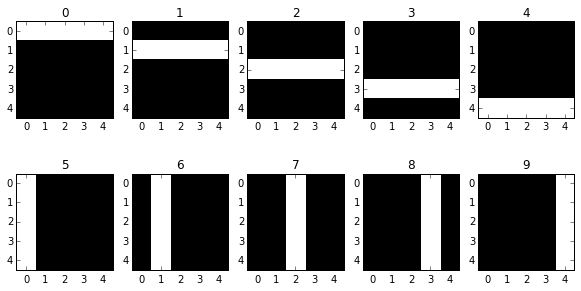

In [3]:
topics = []
topic_base = np.concatenate((np.ones((1, 5)) * 0.2, np.zeros((4, 5))), axis=0).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i * 5))
topic_base = np.concatenate((np.ones((5, 1)) * 0.2, np.zeros((5, 4))), axis=1).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)
plt.figure(figsize=(10, 5))
plot_images(plt, topics, (5, 5), layout=(2, 5), figsize=(10, 5))

### Generate documents from topics

We generate 1,000 documents from these 10 topics by sampling 1,000 topic distributions, one for each document, from a Dirichlet distribution with parameter $\alpha = (1, \ldots, 1)$.

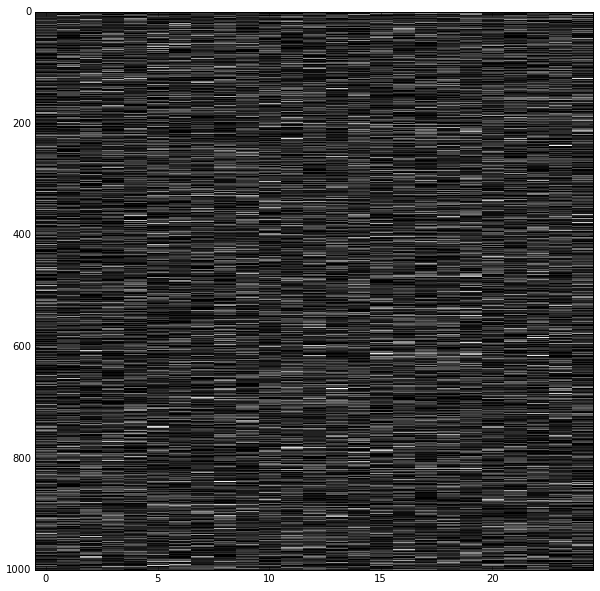

In [4]:
alpha = np.ones(K)
np.random.seed(42)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=100, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
plt.figure(figsize=(10, 10))
imshow(doc_term_matrix, aspect='auto')

### Estimate parameters

Again, much of this comes from [this repository](https://github.com/ariddell/lda/).  However, my class is about twice as fast as the one there.

In [5]:
%load_ext cython

In [6]:
%%cython -lgsl
#cython: language_level=3
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True

import numbers
import numpy as np
from numpy cimport (ndarray, float64_t)
from cython cimport (boundscheck, wraparound, cdivision)
from cython.operator cimport (preincrement, predecrement)
from cython_gsl cimport gsl_sf_lngamma as lgamma


cdef int searchsorted(double[:] arr, int length, double value):
    """
    Bisection search (c.f. numpy.searchsorted)
    Find the index into sorted array `arr` of length `length` such that, if
    `value` were inserted before the index, the order of `arr` would be
    preserved.
    """
    cdef:
        int imin = 0
        int imax = length
        int imid
    while imin < imax:
        imid = imin + ((imax - imin) >> 2)
        if value > arr[imid]:
            imin = imid + 1
        else:
            imax = imid
    return imin


cdef double loglikelihood(int[:, :] nzw, int[:, :] ndz,
                          int[:] nz, int[:] nd,
                          double[:] alpha, double[:] beta,
                          double sum_alpha, double sum_beta,
                          double lBeta_alpha, double lBeta_beta,
                          double lgamma_sum_alpha_nd):
    cdef int k, d
    cdef int n_docs = ndz.shape[0]
    cdef int n_topics = ndz.shape[1]
    cdef int n_terms = nzw.shape[1]
    cdef double ll = 0
    # calculate log p(w|z)
    ll += n_topics * lBeta_beta
    for k in range(n_topics):
        ll -= lgamma(sum_beta + nz[k])
        for w in range(n_terms):
            ll += lgamma(beta[w] + nzw[k, w])
    # calculate log p(z)
    ll += n_docs * lBeta_alpha
    ll -= lgamma_sum_alpha_nd
    for d in range(n_docs):
        for k in range(n_topics):
            ll += lgamma(alpha[k] + ndz[d, k])
    return ll


class LDA(object):
    """
    myLDA is my LDA, implemented in Cython!
    
    Parameters
    ----------
    n_topics : int
        Number of topics

    alpha : array-like, shape = (n_topics,)
        Dirichlet distribution parameter for each document's topic distributions
        
    beta : array-like, shape = (n_terms,)
        Dirichlet distribution parameter for each topic's term distributions
        
    n_iter : int, default=500
        Number of iterations of Gibbs sampler
        
    random_state : int, optional
        Seed for random number generator
    """
    def __init__(self, int n_topics, double[:] alpha, double[:] beta, int n_iter=500,
                 random_state=None):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.n_iter = n_iter
        self.rng = self._check_random_state(random_state)

        
    def _check_random_state(self, seed):
        """
        Turn seed into a np.random.RandomState instance
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
        
        I copied this straight from here:
        https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py#L530-L545
        """
        if seed is None or seed is np.random:
            return np.random.mtrand._rand
        if isinstance(seed, (numbers.Integral, np.integer)):
            return np.random.RandomState(seed)
        if isinstance(seed, np.random.RandomState):
            return seed
        raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                         ' instance' % seed)


    def fit(self, X):
        """
        Perform (collapsed) Gibbs sampling inference.
        
        Parameters
        ----------
        X : array-like, shape = (n_docs, n_terms)
            The document-term matrix
        """
        self.doc_term_matrix = X
        _docs, _terms = np.nonzero(X)
        self.n_docs, self.n_terms = X.shape
        self.n_tokens = X.sum()
        self.loglikelihoods = []
        cdef:
            int i, j, k, d, w, z, new_z
            double p_sum, uval
            # creating these local C variables reduces calls to self, and hence the C-API
            int n_iter = self.n_iter
            int n_tokens = self.n_tokens
            int n_topics = self.n_topics
            int n_terms = self.n_terms
            int n_docs = self.n_docs
            double[::1] alpha = np.ascontiguousarray(self.alpha, dtype=np.float64)
            double[::1] beta = np.ascontiguousarray(self.beta, dtype=np.float64)
            double sum_alpha = np.asarray(self.alpha).sum()
            double sum_beta = np.asarray(self.beta).sum()
            double lBeta_alpha = 0.
            double lBeta_beta = 0.
            double lgamma_sum_alpha_nd = 0.
            # convenient lookup tables linking tokens to their docs, terms and topics
            int[::1] doc_lookup = np.ascontiguousarray(np.repeat(_docs, X[_docs, _terms]), dtype=np.intc)
            int[::1] term_lookup = np.ascontiguousarray(np.repeat(_terms, X[_docs, _terms]), dtype=np.intc)
            int[::1] topic_lookup = np.ascontiguousarray(self.rng.randint(0, self.n_topics, size=self.n_tokens),
                                                         dtype=np.intc)
            # number of tokens in document d assigned to topic z, shape = (n_docs, n_topics)
            int[:, ::1] ndz = np.zeros((self.n_docs, self.n_topics), dtype=np.intc, order='C')
            # number of tokens assigned to topic z equal to term w, shape = (n_topics, n_terms)
            int[:, ::1] nzw = np.zeros((self.n_topics, self.n_terms), dtype=np.intc, order='C')
            # number of tokens assigned to topic k, shape = (n_topics,)
            int[::1] nz = np.zeros(self.n_topics, dtype=np.intc, order='C')
            # number of tokens in doc d, shape = (n_docs,)
            int[::1] nd = np.zeros(self.n_docs, dtype=np.intc, order='C')
            # (weighted) probabilities for the discrete distribution
            double[::1] p_cumsum = np.empty(self.n_topics, dtype=np.float64, order='C')
            # preallocate uniformly random numbers on the interval [0, 1)
            double[::1] urands = self.rng.rand(1024**2 // 8)
            int n_urands = urands.shape[0]
            int u = 0
        # initialize counts
        for j in range(n_tokens):
            preincrement(ndz[doc_lookup[j], topic_lookup[j]])
            preincrement(nzw[topic_lookup[j], term_lookup[j]])
            preincrement(nz[topic_lookup[j]])
            preincrement(nd[doc_lookup[j]])
        # initialize lBeta_alpha
        for k in range(n_topics):
            lBeta_alpha += lgamma(alpha[k])
            lBeta_alpha -= lgamma(sum_alpha)
        # initialize lBeta_beta
        for w in range(n_terms):
            lBeta_beta += lgamma(beta[w])
            lBeta_beta -= lgamma(sum_beta)
        # initialize lgamma_sum_alpha_nd
        for d in range(n_docs):
            lgamma_sum_alpha_nd += lgamma(sum_alpha + nd[d])
        # iterate
        for i in range(n_iter):
            for j in range(n_tokens):
                d = doc_lookup[j]
                w = term_lookup[j]
                z = topic_lookup[j]
                predecrement(ndz[d, z])
                predecrement(nzw[z, w])
                predecrement(nz[z])
                p_sum = 0.
                for k in range(n_topics):
                    p_sum += (nzw[k, w] + beta[w]) / (nz[k] + sum_beta) * (ndz[d, k] + alpha[k]) 
                    p_cumsum[k] = p_sum
                preincrement(u)
                if u == n_urands:
                    u = 0
                uval = urands[u] * p_sum
                new_z = topic_lookup[j] = searchsorted(p_cumsum, n_topics, uval)
                preincrement(ndz[d, new_z])
                preincrement(nzw[new_z, w])
                preincrement(nz[new_z])
            self.loglikelihoods.append(loglikelihood(nzw, ndz, nz, nd,
                                                     alpha, beta, sum_alpha, sum_beta,
                                                     lBeta_alpha, lBeta_beta, lgamma_sum_alpha_nd))
        # populate the topic and word distributions
        self.theta = np.asarray(ndz) + np.tile(self.alpha, (self.n_docs, 1))
        self.theta = (self.theta.T / self.theta.sum(axis=1)).T
        self.phi = np.asarray(nzw) + np.tile(self.beta, (self.n_topics, 1))
        self.phi = (self.phi.T / self.phi.sum(axis=1)).T        

In [7]:
lda = LDA(10, 0.1 * np.ones(K), 0.01 * np.ones(V), 300, random_state=42)

In [8]:
%%time
lda.fit(doc_term_matrix)

CPU times: user 3.41 s, sys: 7.09 ms, total: 3.41 s
Wall time: 3.41 s


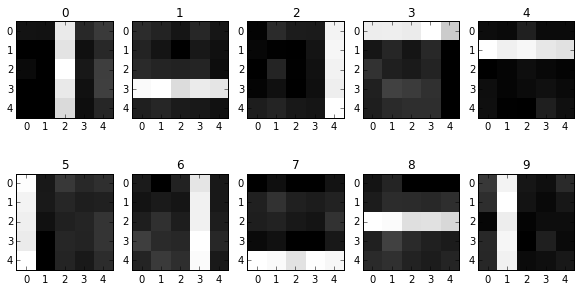

In [9]:
plot_images(plt, lda.phi, (5, 5), (2, 5), figsize=(10, 5))

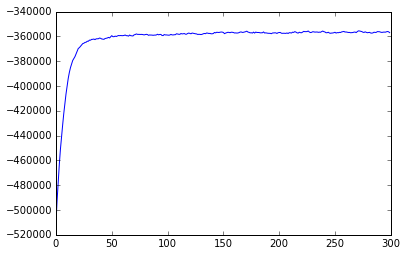

In [10]:
plt.plot(lda.loglikelihoods)